#  imports and utils

In [1]:
#export
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
import pandas as pd
from functools import partial
import pdb
import pickle
from collections import defaultdict
from sklearn.model_selection import train_test_split

In [3]:
#export
import numpy as np
import gc
from tqdm import tqdm_notebook as tqdm

In [4]:
#export
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset,DataLoader
from torch.optim import Adam
from torch import tensor

In [5]:
#export
import matplotlib.pyplot as plt

In [6]:
!ls ../data

sample_submission.csv  test_transaction.csv  train_transaction.csv
test_identity.csv      train_identity.csv    zips


In [7]:
#export
data_pth = '../data/'

In [8]:
#export
trn_id = pd.read_csv(data_pth+'train_identity.csv',index_col='TransactionID')

In [9]:
trn_id.head(2)

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device


In [10]:
#export
from typing import Iterable

In [11]:
#export
def listify(p=None):
    if p is None: p=[]
    elif isinstance(p, str):          p = [p]
    elif not isinstance(p, Iterable): p = [p]
    return p

# DF Handler

In [151]:
#export
class DfHandler():
    def __init__(self,df, cont=None, cat=None,dep_var=None):
        '''
        creates cont and cat variable lists
        '''
        self.cont = listify(cont)
        self.cat = listify(cat)
        self.dep_var = dep_var
        if self.cont:
            self.cat = set(list(df.columns)) - set(self.cont)
            self.cat = list(self.cat)
        elif self.cat:
            self.cont = set(list(df.columns)) - set(self.cat)
            self.cont = list(self.cont)
        if dep_var in self.cat:
            self.cat.remove(dep_var)
        elif dep_var in self.cont:
            self.cont.remove(dep_var)
        assert (len(df.columns) == len(self.cat)+len(self.cont))+1, "some columns are missed"
    
    def parse_frame(self,df):
        '''
        1
        calculate features dictionary, for cont features
        we get mean and std, for cat features we store all possible values
        of cateogery.
        '''
        self.feat_dist = {}
        for col in df.columns:
            if col in self.cat:
                self.feat_dist[col] = np.array(df[col].dropna().unique())
            elif col in self.cont:
                self.feat_dist[col] = np.array([df[col].mean(),df[col].std()])
                if (df[col].std() != df[col].std()):
                    print('std is nan')
    
    def add_nan_cols(self,df):
        '''
        2
        if a  cloumn has Nan in it create a new column next to it
        value is True if Nan else False
        '''
        cols_2_probe = list(df.columns.values)
        cols_2_probe.remove(self.dep_var)
        len_df = 0
        while len(df.columns)-1 == 2*len(cols_2_probe):
            for col in cols_2_probe:
                df.insert(self.get_loc(df,col)+1,col+'_isnan',df[col].isna())
                break
        self.cat.extend([col+'_isnan' for col in df.columns if col+'_isnan' in df.columns])
        return df
    
    def get_loc(self,df,col):
        '''
        get the location of the given column.
        '''
        for idx,col_ in enumerate(df.columns):
            if col_ == col:
                return idx
            
    def replace_nans(self,df):
        '''
        3
        replace NaNs in a DataFrame with stats taken during parse
        check if the changes are being reflected in the df
        '''
        for col in df.columns:
            if df[col].isna().sum()>0:
                if col in self.cat:
                    no_nan_feat = len(self.feat_dist[col])
                    if df[col].isna().sum() > 0:
                        if no_nan_feat == 1:
                            df[col][df[col+'_isnan']] = self.feat_dist[col][0]
                        else:
                            df[col][df[col+'_isnan']] = self.feat_dist[col][np.random.randint(0,no_nan_feat-1,df[col+'_isnan'].sum())]
                elif col in self.cont:
                    no_nan_feat = len(self.feat_dist[col])
                    m = self.feat_dist[col][0]
                    s = self.feat_dist[col][1]
                    df[col][df[col+'_isnan']] = np.random.uniform(-1,1,df[col+'_isnan'].sum())*s + m
        return df
    
    def to_cats(self,df):
        '''
        4
        get all cat vars and convert to cat dtype
        '''
        self.col_2_cat = {} #columns to category number map
        for col in self.cat:
            df[col] = df[col].astype('category').cat.as_ordered()
            self.col_2_cat[col] = df[col].cat.categories
            df[col] = df[col].cat.codes
        return df 
    
    def cat_cont_y_sep(self,df,dep_var):
        '''
        5
        sep cat, cont feat to feed to the model
        '''
        if dep_var in self.cat:
            self.cat.remove(dep_var)
        elif dep_var in self.cont:
            self.cont.remove(dep_var)
        a,b = df.loc[:,self.cat].values, df.loc[:,self.cont].values
        # patch to work with both trn and tst df, as tst has no dep_var col
        if dep_var in df.columns:
            y = df.loc[:,dep_var].values
        else:
            y = [0]*len(df)
        a,b,y = torch.tensor(a,dtype=torch.long),torch.tensor(b,dtype=torch.float),torch.tensor(y,dtype=torch.float)
        return a,b,y
    
    def get_dataset(self,df,dep_var):
        '''6
        ds from df'''

        cat_dat, cont_dat,y = self.cat_cont_y_sep(df,dep_var)
        ds = TensorDataset(cat_dat,cont_dat,y)
        return ds
        
    def get_dl(self,ds,bs,shuffle,num_workers,**kwargs):
        '''7
        dl from ds'''
        return DataLoader(ds,bs,shuffle,num_workers=num_workers,**kwargs)
    
    def norm_df(self,df):
        df_ = df.copy()
        for col in self.cont:
            df_[col] = (df[col] - self.feat_dist[col][0])/self.feat_dist[col][1]
        return df_
    
    def check_cols(self,col_trn,col_tst):
        '''return True if both col names are exactly same'''
        for i in range(len(col_trn.columns)):
            if col_trn.columns[i] != col_tst.columns[i]:
                return False
        return True 
        
    def prep_tst_df(self,df_tst,df_trn,cat_cols,cont_cols):
        # continue here
        '''
        1) is null cols
        normalizing
        cats handling
        '''
        # add just as many is_null cols at the same pos as in train ds
        i = 0
        while not self.check_cols(df_trn,df_tst) :
            i += 1
            if(i>600):
                print("error: more than 800 iters to work on tst_df")
                break
            for i,col in enumerate(df_trn.columns):
                if df_tst.columns[i] != col:
                    df_tst.insert(i,col,df_tst[col[:-6]].isna())
                    break
        # cats handling
        for col in cat_cols:
            df_tst[col].apply(lambda x: np.where(self.col_2_cat[col] == x)[0])
        # normalize cont vars
        for col in cont_cols:
            df_tst[col] = (df_tst[col] - self.feat_dist[col][0])/self.feat_dist[col][1]
            
        return df_tst
        

In [131]:
df.columns.values.remove()

AttributeError: 'numpy.ndarray' object has no attribute 'remove'

In [14]:
np.where(ptr.dfh.col_2_cat['card1'] == 1004)[0]

NameError: name 'ptr' is not defined

# PTTRN recog

In [146]:
#export
class PtrnRecog():
    def __init__(self,df,cont=None,cat=None,dep_var=None):
        self.dep_var = dep_var
        self.dfh = DfHandler(df,cont,cat,dep_var)
        # calc distrubutions of features and add isnan fetures
        self.dfh.parse_frame(df)
        #pdb.set_trace()
        self.df = self.dfh.add_nan_cols(df)
        
        self.cont = self.dfh.cont
        self.cat = self.dfh.cat
        
        self.lf = nn.MSELoss()
        self.losses,self.losses_val = [],[]
    
    def get_data_ready(self,bs,shuffle,num_workers,**kwargs):
        self.bs = bs
        self.shuffle = shuffle
        self.num_workers = num_workers
        self.kwargs = kwargs
        self.df = self.dfh.replace_nans(self.df)
        pdb.set_trace()
        self.df = self.dfh.to_cats(self.df)
        #self.dfn = self.dfh.norm_df(self.df)
        # repeat work being done in shuffle_nans
        #self.ds = self.dfh.get_dataset(self.dfn,self.dep_var)
        #self.dl = self.dfh.get_dl(self.ds,self.bs,self.shuffle,self.num_workers,**self.kwargs)
        
    def shuffle_nans(self):
        self.df = self.dfh.replace_nans(self.df)
        self.dfn = self.dfh.norm_df(self.df) # df normalized
        
        self.dfn_trn,self.dfn_val = train_test_split(self.dfn,test_size=0.3)
        
        self.ds_trn = self.dfh.get_dataset(self.dfn_trn,self.dep_var)
        self.ds_val = self.dfh.get_dataset(self.dfn_val,self.dep_var)
        
        self.dl_trn = self.dfh.get_dl(self.ds_trn,self.bs,self.shuffle,self.num_workers,**self.kwargs)
        self.dl_val = self.dfh.get_dl(self.ds_val,self.bs*4,self.shuffle,self.num_workers,**self.kwargs)
    
    def get_model(self,h1,h2):
        self.m = TabularNN(self.df,self.cat,len(self.cont),h1,h2)
    
    def get_opt(self):
        self.opt = Adam(self.m.parameters())
        
    def fit(self):
        #self.losses = []
        self.m.train()
        for d_cat,d_cont,y in tqdm(self.dl_trn):
            if self.gpu:
                d_cat,d_cont,y = d_cat.cuda(),d_cont.cuda(),y.cuda()
            self.opt.zero_grad()
            preds_b = self.m(d_cat,d_cont,y)
            loss = self.lf(preds_b,y)
            loss.backward()
            self.opt.step()
            self.losses.append(loss.item())
            
        self.m.eval()
        with torch.no_grad():
            for d_cat,d_cont,y in tqdm(self.dl_val):
                if self.gpu:
                    d_cat,d_cont,y = d_cat.cuda(),d_cont.cuda(),y.cuda()
                preds_b = self.m(d_cat,d_cont,y)
                loss = self.lf(preds_b,y)
                self.losses_val.append(loss.item())
            
    def predict(self,df):
        self.makeup_test_df(df)
        preds = []
        for d_cat,d_cont,y in tqdm(self.dl_tst):
            if self.gpu:
                d_cat,d_cont,y = d_cat.cuda(),d_cont.cuda(),y.cuda()
                
                preds_b = self.m(d_cat,d_cont,y)
                preds.append(preds_b)
        return preds
        
    def learn(self,epochs):
        for epoch in range(epochs):
            print(epoch)
            self.shuffle_nans()
            self.fit()
            
    def to_gpu(self):
        self.gpu = True
        self.m.cuda()
    
    def makeup_test_df(self,df):
        self.df_tst =  self.dfh.prep_tst_df(df,self.df,self.cat,self.cont)
        self.ds_tst = self.dfh.get_dataset(self.df_tst,self.dep_var)
        self.dl_tst = self.dfh.get_dl(self.ds_tst,self.bs*4,False,self.num_workers)#shuffle,num_workers
    

#  RBN

In [16]:
#export
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('factor', tensor(0.))
        self.register_buffer('offset', tensor(0.))
        self.batch = 0

    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s    = x    .sum(dims, keepdim=True)
        ss   = (x*x).sum(dims, keepdim=True)
        c    = s.new_tensor(x.numel()/nc)
        mom1 = s.new_tensor(1 - (1-self.mom)/math.sqrt(bs-1))
        self.sums .lerp_(s , mom1)
        self.sqrs .lerp_(ss, mom1)
        self.count.lerp_(c , mom1)
        self.batch += bs
        means = self.sums/self.count
        varns = (self.sqrs/self.count).sub_(means*means)
        if bool(self.batch < 20): varns.clamp_min_(0.01)
        self.factor = self.mults / (varns+self.eps).sqrt()
        self.offset = self.adds - means*self.factor

    def forward(self, x):
        if self.training: self.update_stats(x)
        return x*self.factor + self.offset

# G RELU

In [17]:
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x):
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

# Model

In [18]:
#export
class TabularNN(nn.Module):
    def __init__(self,df,cat_cols, cont_featsz, h1,h2):
        super().__init__()
        self.nuniq = df[cat_cols].nunique().values
        self.emb_szs = np.array(list(map(lambda x: min(50, round(1.6* x**0.56)), self.nuniq)), dtype=int)
        #print(self.nuniq,self.emb_szs)
        self.embs = nn.ModuleList([nn.Embedding(n,sz) for n,sz in zip(self.nuniq,self.emb_szs)])
        
        self.f_sz = 0
        for sz in self.emb_szs:
            self.f_sz += sz
        self.f_sz += cont_featsz
        
        self.rbn1 = RunningBatchNorm(self.f_sz)
        self.l1 = nn.Linear(self.f_sz,h1)
        self.nl1 = nn.ReLU()
        self.rbn2 = RunningBatchNorm(h1)
        self.l2 = nn.Linear(h1,h2)
        self.nl2 = nn.ReLU()
        self.rbn3 = RunningBatchNorm(h2)
        self.f1 = nn.Linear(h2,1)
        self.sig = nn.Sigmoid()
        
    def forward(self,d_cat,d_cont,y):
        x = [e(d_cat[:,i]) for i,e in enumerate(self.embs)]
        x.append(d_cont)
        x = torch.cat(x,dim=1)
        x = self.nl1(self.l1(x))
        x = self.nl2(self.l2(x))
        x = self.f1(x)
        x = self.sig(x)
        return x.squeeze(1)

# Hook

In [19]:
#export
class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def append_stats(hook, mod, inp, outp):
    #pdb.set_trace()
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    means,stds = hook.stats
    if mod.training:
        means.append(outp.data.mean())
        stds .append(outp.data.std())
        
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        try: return self.items[idx]
        except TypeError:
            if isinstance(idx[0],bool):
                assert len(idx)==len(self) # bool mask
                return [o for m,o in zip(idx,self.items) if m]
            return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res
    
class Hooks(ListContainer):
    def __init__(self, ms, f):
        ms = list(ms.children())[1:]
        super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)

    def remove(self):
        for h in self: h.remove()

# prac 

In [17]:
# use pandas internal cateogery handling to make cat vars as pandas cats
# convert rest to float.

# add dep var to data proc pipeline

# create a model

In [135]:
df = trn_id.sample(200)

df = df.loc[:,'id_03':'id_09']

In [136]:
df.head(3)

,id_03,id_04,id_05,id_06,id_07,id_08,id_09
TransactionID,,,,,,,
3072632,NaN,NaN,0.0,0.0,NaN,NaN,0.0
3095294,NaN,NaN,0.0,-1.0,NaN,NaN,0.0
3083182,0.0,0.0,0.0,0.0,NaN,NaN,0.0


In [139]:
df.columns[5] == df.columns[6]

False

In [ ]:
df['id_05'].astype('cateogery')

In [17]:
#! conda install -c conda-forge ipdb -y

In [18]:
import ipdb

In [19]:
dfh = DfHandler(df,cat=['id_03','id_04'])

In [20]:
dfh.parse_frame(df)

In [ ]:
df1 = dfh.add_nan_cols(df)

In [ ]:
df1 = dfh.replace_nans(df1)

In [ ]:
df1 = dfh.to_cats(df1)

In [ ]:
df1.head(5)

In [ ]:
a,b,y = dfh.cat_cont_y_sep(df1,'id_09')

In [ ]:
a.shape

In [ ]:
b.shape

In [ ]:
df1.shape

In [ ]:
y.shape

In [ ]:
ds = dfh.get_dataset(df1,'id_09')

In [ ]:
m = TabularNN(df1,dfh.cat,len(dfh.cont),20,10)

In [ ]:
m(a,b,y)

In [ ]:
a,b,y

# PR test

In [ ]:
_ = torch.tensor([1,5,6])

In [ ]:
_.squeeze_()

In [90]:
# id_01,12 has no miss

In [152]:
df = trn.sample(8000)

In [153]:
df.head(3)

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
3411575,0,10755792,335.000,W,18343,374.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3409797,0,10702782,25.950,W,12544,321.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3446636,0,11807305,141.158,C,12330,149.0,147.0,mastercard,219.0,credit,...,safari generic,NaN,NaN,NaN,F,F,T,F,desktop,NaN


In [154]:
ptr = PtrnRecog(df,cat=cats,dep_var=dep_var)

In [155]:
ptr.get_data_ready(512,False,12)

KeyError: 'card2_isnan'

In [ ]:
ptr.get_model(40,20)

In [25]:
list(ptr.m.children())[1:]

[RunningBatchNorm(),
 Linear(in_features=36, out_features=40, bias=True),
 ReLU(),
 RunningBatchNorm(),
 Linear(in_features=40, out_features=20, bias=True),
 ReLU(),
 RunningBatchNorm(),
 Linear(in_features=20, out_features=1, bias=True),
 Sigmoid()]

In [26]:
ptr.to_gpu()

In [27]:
ptr.get_opt()

In [28]:
ptr.opt

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [29]:
ms,ss = [],[]

In [30]:
ptr.learn(2)

0



1


0



1



No
yes
yes
No
yes
yes
No
yes
yes


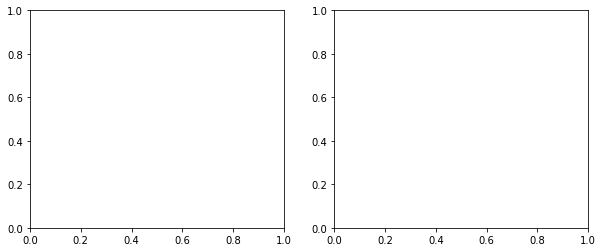

In [31]:
with torch.autograd.set_detect_anomaly(True):
    with Hooks(ptr.m, append_stats) as hooks:
        ptr.learn(2)
        fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
        for h in hooks:
            if hasattr(h,'stats'):
                print('yes')
            else:
                print('No')
        #ms,ss = getattr(h,'stats',(None,None))
        #ax0.plot(ms)
        #ax1.plot(ss)
    #plt.legend(range(len(hooks)));

In [32]:
pds = ptr.predict(df)

In [33]:
pds[:10]

[tensor([0.0755, 0.0867, 0.0408,  ..., 0.0278, 0.0368, 0.0295], device='cuda:0',
        grad_fn=<SqueezeBackward1>),
 tensor([0.0627, 0.0563, 0.0158,  ..., 0.0737, 0.1014, 0.0354], device='cuda:0',
        grad_fn=<SqueezeBackward1>),
 tensor([0.0463, 0.0332, 0.0741,  ..., 0.0505, 0.0837, 0.0706], device='cuda:0',
        grad_fn=<SqueezeBackward1>),
 tensor([0.0733, 0.0305, 0.0047,  ..., 0.0590, 0.0606, 0.0341], device='cuda:0',
        grad_fn=<SqueezeBackward1>),
 tensor([0.0245, 0.0635, 0.0437, 0.0817, 0.0306, 0.0329, 0.0415, 0.0170, 0.0369,
         0.0521, 0.1083, 0.0269, 0.0564, 0.0308, 0.0376, 0.0577, 0.0809, 0.0365,
         0.0359, 0.0476, 0.0272, 0.0306, 0.0995, 0.0241, 0.0520, 0.0273, 0.0345,
         0.0703, 0.0509, 0.0391, 0.0286, 0.0366, 0.0267, 0.0866, 0.0922, 0.0435,
         0.0342, 0.0315, 0.0324, 0.0788, 0.0590, 0.0351, 0.1035, 0.0343, 0.0881,
         0.0826, 0.1341, 0.0622, 0.0240, 0.0315, 0.0282, 0.0782, 0.0276, 0.0264,
         0.0419, 0.0242, 0.0673, 0.0745, 0

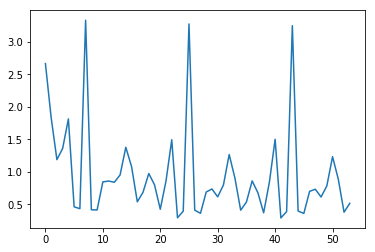

In [33]:
plt.plot(ptr.losses)

0
1
2


# Train

##  create df

In [18]:
trn_tran = pd.read_csv(data_pth+'train_transaction.csv',index_col='TransactionID')

In [19]:
trn_tran.head(2)

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
a = ['id_'+str(n) for n in range(12,39,1)]

In [21]:
cats = ['ProductCD','card1','card2','card3','card4','card5','card6','addr1','addr2','P_emaildomain','R_emaildomain',
       'M1','M2','M3','M4','M5','M6','M7','M8','M9',
       'DeviceType','DeviceInfo']
cats.extend(a)
dep_var = 'isFraud'

In [22]:
trn_id.shape, trn_tran.shape

((144233, 40), (590540, 393))

In [23]:
trn = trn_tran.join(trn_id)

In [29]:
trn.shape

(590540, 433)

In [25]:
del trn_tran
del trn_id
gc.collect()

154

In [28]:
#with open('trn.pickle','wb') as fl:
#    pickle.dump(trn,fl)

with open('trn.pickle','rb') as fl:
    trn = pickle.load(fl)

##  start learning

In [37]:
a = ['id_'+str(n) for n in range(12,39,1)]

In [38]:
cats = ['ProductCD','card1','card2','card3','card4','card5','card6','addr1','addr2','P_emaildomain','R_emaildomain',
       'M1','M2','M3','M4','M5','M6','M7','M8','M9',
       'DeviceType','DeviceInfo']
cats.extend(a)
dep_var = 'isFraud'

In [124]:
with open('trn.pickle','rb') as fl:
    trn = pickle.load(fl)

In [128]:
trn.isna().sum() == 0

isFraud            True
TransactionDT      True
TransactionAmt     True
ProductCD          True
card1              True
card2             False
card3             False
card4             False
card5             False
card6             False
addr1             False
addr2             False
dist1             False
dist2             False
P_emaildomain     False
R_emaildomain     False
C1                 True
C2                 True
C3                 True
C4                 True
C5                 True
C6                 True
C7                 True
C8                 True
C9                 True
C10                True
C11                True
C12                True
C13                True
C14                True
                  ...  
id_11             False
id_12             False
id_13             False
id_14             False
id_15             False
id_16             False
id_17             False
id_18             False
id_19             False
id_20             False
id_21           

In [121]:
trn.head(2)

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
ptr = PtrnRecog(trn,cat=cats,dep_var=dep_var)

In [123]:
ptr.get_data_ready(512,False,12)

/home/ravi/miniconda3/envs/fastpy3/lib/python3.7/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ravi/miniconda3/envs/fastpy3/lib/python3.7/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


> <ipython-input-114-2507f33470e1>(22)get_data_ready()
-> self.df = self.dfh.to_cats(self.df)
(Pdb) s
--Call--
> <ipython-input-93-fdcc56d5c28b>(78)to_cats()
-> def to_cats(self,df):
(Pdb) len(self.cat)
4029
(Pdb) len(df.columns)
847
(Pdb) c


In [65]:
ptr.get_model(40,20)

In [66]:
ptr.to_gpu()

In [67]:
ptr.get_opt()

0


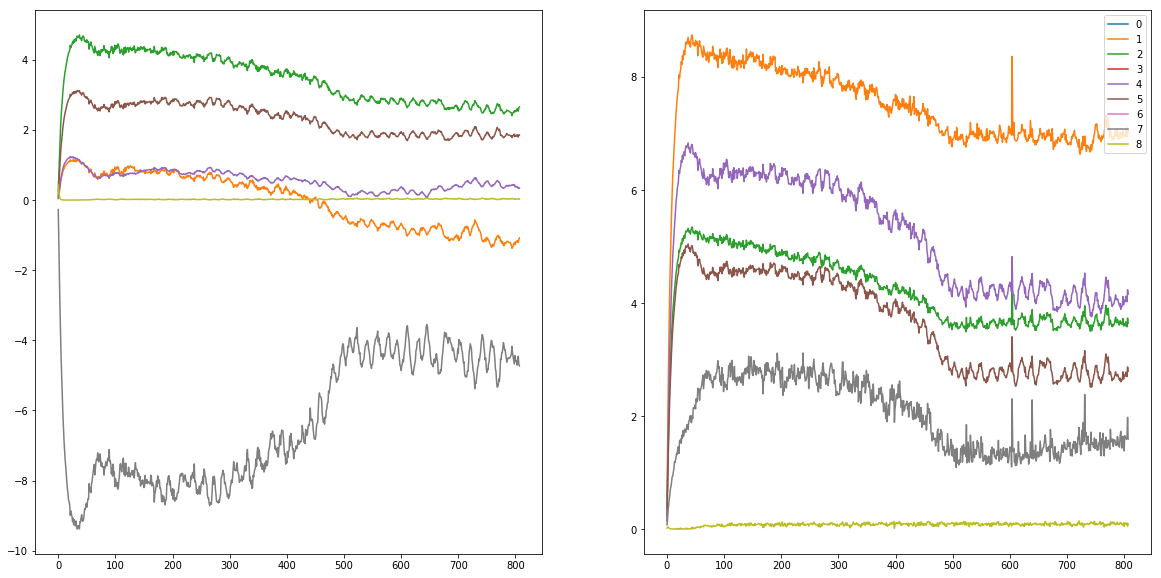

In [72]:
mss,sss = {},{}
with Hooks(ptr.m, append_stats) as hooks:
    ptr.learn(1)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(20,10))
    for i,h in enumerate(hooks):
        ms,ss = getattr(h,'stats',(0,1))
        mss[i] = ms
        sss[i] = ss
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(len(hooks)))

In [80]:
mss[6] #0,3,6

0

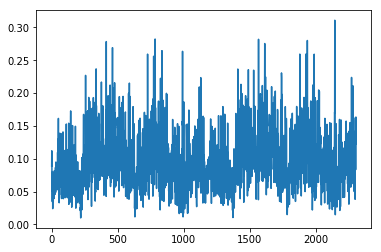

In [96]:
plt.plot(sss[7])

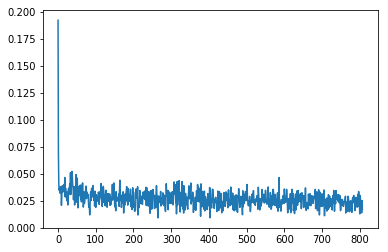

In [73]:
plt.plot(ptr.losses)

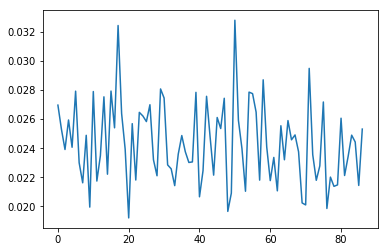

In [74]:
plt.plot(ptr.losses_val)

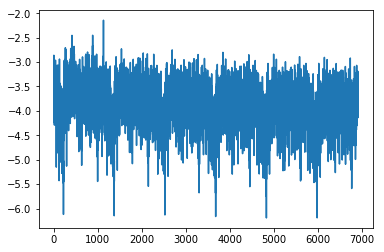

In [99]:
plt.plot(np.log(ptr.losses))

In [50]:
len(ptr.losses)/11

1154.0

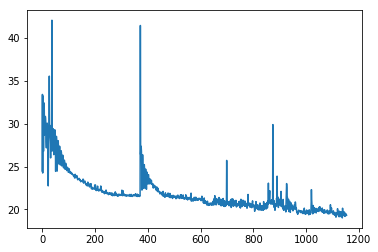

In [69]:
plt.plot(np.log(ptr.losses[-1154:]))

#  predict

In [55]:
tst_id = pd.read_csv(data_pth+'test_identity.csv',index_col='TransactionID')
tst_tran = pd.read_csv(data_pth+'test_transaction.csv',index_col='TransactionID')

In [56]:
tst = tst_tran.join(tst_id)

In [57]:
tst.shape

(506691, 432)

In [75]:
#with open('tst.pickle','wb') as fl:
#    pickle.dump(tst,fl)
    
with open('tst.pickle','rb') as fl:
    tst = pickle.load(fl)

In [81]:
dep_var in ptr.dfh.cont

False

In [76]:
preds_tst = ptr.predict(tst)

KeyError: 'i'

In [61]:
trn.head(2)

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card2_isnan,card3,card3_isnan,card4,...,id_36,id_36_isnan,id_37,id_37_isnan,id_38,id_38_isnan,DeviceType,DeviceType_isnan,DeviceInfo,DeviceInfo_isnan
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,4,10095,34,1,42,0,1,...,0,1,1,1,1,1,1,1,774,1
2987001,0,86401,29.0,4,1372,303,0,42,0,2,...,0,1,1,1,1,1,1,1,928,1


In [60]:
tst.head(2)

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,299.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# EXPORT

In [157]:
!python notebook2script.py Untitled.ipynb

Converted Untitled.ipynb to exp/nb_Untitled.py
